In [22]:
import torch
import torch
import torch.nn as nn
from torch.nn import Linear, Conv2d, BatchNorm1d, BatchNorm2d, PReLU, Sequential, Module
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import torch.optim as optim
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# device = torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


In [23]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
import torch

class RAFDBDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.labels = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.img_dir, self.labels.iloc[idx, 0])
        image = Image.open(img_name)
        label = self.labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)

        return image, label

In [24]:
from rafdb_dataset import RAFDBDataset

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=3),
    # transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # transforms.RandomErasing(scale=(0.02,0.25)),
])
    
rafdb_dataset_train = RAFDBDataset(csv_file='data/train_labels.csv',
                            img_dir='data/train/',
                            transform=transform)
# rafdb_dataset_train = RAFDBDataset(csv_file='archive/FER+/train_FER_labels.csv',
#                             img_dir='archive/FER+/train/',
#                             transform=transform)
data_train_loader = DataLoader(rafdb_dataset_train, batch_size=16, shuffle=True, num_workers=4)
train_image, train_label = next(iter(data_train_loader))
print(f"Train batch: image shape {train_image.shape}, labels shape {train_label.shape}")

rafdb_dataset_vali = RAFDBDataset(csv_file='data/vali_labels.csv',
                            img_dir='data/vali',
                            transform=transform)
data_vali_loader = DataLoader(rafdb_dataset_vali, batch_size=16, shuffle=False, num_workers=0)
vali_image, vali_label = next(iter(data_vali_loader))
print(f"Vali batch: image shape {vali_image.shape}, labels shape {vali_label.shape}")

rafdb_dataset_test = RAFDBDataset(csv_file='data/test_RAF_labels.csv',
                            img_dir='data/test/',
                            transform=transform)
# rafdb_dataset_test = RAFDBDataset(csv_file='archive/FER+/test_FER_labels.csv',
#                             img_dir='archive/FER+/test/',
#                             transform=transform)
data_test_loader = DataLoader(rafdb_dataset_test, batch_size=16, shuffle=False, num_workers=0)
test_image, test_label = next(iter(data_test_loader))
print(f"Test batch: image shape {test_image.shape}, labels shape {test_label.shape}")

Train batch: image shape torch.Size([16, 3, 64, 64]), labels shape torch.Size([16])
Vali batch: image shape torch.Size([16, 3, 64, 64]), labels shape torch.Size([16])
Test batch: image shape torch.Size([16, 3, 64, 64]), labels shape torch.Size([16])


In [25]:
class SEBlock(nn.Module): # Squeeze-and-Excitation (SE) blocks apply channel-wise attention.
    def __init__(self, input_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(input_channels, input_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(input_channels // reduction, input_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

In [26]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  
        out = F.relu(out)
        return out

In [27]:
# Residual 
# class EmotionClassifier(nn.Module):
#     def __init__(self):
#         super(EmotionClassifier, self).__init__()
#         self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.relu = nn.ReLU(inplace=True)
#         self.se1 = SEBlock(64)

#         # Using Residual Blocks
#         self.res_block1 = ResidualBlock(64, 128, stride=2)
#         self.res_block2 = ResidualBlock(128, 256, stride=2)
#         self.res_block3 = ResidualBlock(256, 512, stride=2)
#         self.res_block4 = ResidualBlock(512, 1024, stride=2)

#         self.pool = nn.AdaptiveAvgPool2d((1, 1))
#         self.fc1 = nn.Linear(1024, 2048)
#         self.fc2 = nn.Linear(2048, 1024) 
#         self.dropout1 = nn.Dropout(0.5)
#         self.fc3 = nn.Linear(1024, 6)

#     def forward(self, x):
#         x = self.relu(self.bn1(self.conv1(x)))
#         x = self.se1(x)
        
#         x = self.res_block1(x)
#         x = self.res_block2(x)
#         x = self.res_block3(x)
#         x = self.res_block4(x)
        
#         x = self.pool(x)
#         x = x.view(x.size(0), -1)
#         x = F.relu(self.fc1(x))
#         x = self.dropout1(x)
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x
    
# model = EmotionClassifier().to(device)

In [28]:
class EmotionClassifier(nn.Module):
    def __init__(self):
        super(EmotionClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(1024)

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(1024, 2048)
        self.fc2 = nn.Linear(2048, 1024) 
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(1024, 6)

    def forward(self, x): # (batch_size, channels=3, 64, 64)
        x = F.relu(self.bn1(self.conv1(x))) # (batch_size, 64, 64, 64)
        x = F.max_pool2d(x, 2) # (batch_size, 64, 32, 32)
        # x = self.dropout1(x)
        x = F.relu(self.bn2(self.conv2(x))) # (batch_size, 128, 32, 32)
        x = F.max_pool2d(x, 2) # (batch_size, 128, 16, 16)
        x = self.dropout1(x)
        x = F.relu(self.bn3(self.conv3(x))) # (batch_size, 256, 16, 16)
        x = F.max_pool2d(x, 2) # (batch_size, 256, 8, 8)
        # x = self.dropout1(x)
        x = F.relu(self.bn4(self.conv4(x))) # (batch_size, 512, 8, 8)
        x = F.max_pool2d(x, 2) # (batch_size, 512, 4, 4)
        x = self.dropout1(x)
        x = F.relu(self.bn5(self.conv5(x))) # (batch_size, 1024, 4, 4)
        x = F.max_pool2d(x, 2) # (batch_size, 1024, 2, 2)
        # x = self.dropout1(x)
        
        x = self.pool(x) # (batch_size, 1024, 1, 1)
        x = x.view(x.size(0), -1) # (batch_size, 1024) # Flatten
        x = F.relu(self.fc1(x)) # (batch_size, 2048)
        x = self.dropout2(x) # (batch_size, 2048)
        x = F.relu(self.fc2(x)) # (batch_size, 1024)
        x = self.fc3(x) # (batch_size, 6)
        return x

model = EmotionClassifier().to(device)

In [29]:
# model.load_state_dict(torch.load('best_baseline.pth', map_location=device))
# model.eval()

In [30]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 10478086


In [31]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class BasicBlock(nn.Module):
#     expansion = 1

#     def __init__(self, in_planes, planes, stride=1):
#         super(BasicBlock, self).__init__()
#         self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(planes)
#         self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
#         self.bn2 = nn.BatchNorm2d(planes)

#         self.shortcut = nn.Sequential()
#         if stride != 1 or in_planes != self.expansion * planes:
#             self.shortcut = nn.Sequential(
#                 nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
#                 nn.BatchNorm2d(self.expansion * planes)
#             )

#     def forward(self, x):
#         out = F.relu(self.bn1(self.conv1(x)))
#         out = self.bn2(self.conv2(out))
#         out += self.shortcut(x)
#         out = F.relu(out)
#         return out

# class ResNet(nn.Module):
#     def __init__(self, block, num_blocks, num_classes=6):
#         super(ResNet, self).__init__()
#         self.in_planes = 64

#         self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
#         self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
#         self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
#         self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
#         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
#         self.fc = nn.Linear(512 * block.expansion, num_classes)

#     def _make_layer(self, block, planes, num_blocks, stride):
#         strides = [stride] + [1]*(num_blocks-1)
#         layers = []
#         for stride in strides:
#             layers.append(block(self.in_planes, planes, stride))
#             self.in_planes = planes * block.expansion
#         return nn.Sequential(*layers)

#     def forward(self, x):
#         out = F.relu(self.bn1(self.conv1(x)))
#         out = self.layer1(out)
#         out = self.layer2(out)
#         out = self.layer3(out)
#         out = self.layer4(out)
#         out = self.avgpool(out)
#         out = out.view(out.size(0), -1)
#         out = self.fc(out)
#         return out

# def EmotionClassifierResNet18():
#     return ResNet(BasicBlock, [2, 2, 2, 2])

# model = EmotionClassifierResNet18().to(device)


In [32]:
# import torch.nn as nn
# import torch.nn.functional as F

# class VGGEmotionClassifier(nn.Module):
#     def __init__(self):
#         super(VGGEmotionClassifier, self).__init__()
        
#         self.features = nn.Sequential(
#             nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),

#             nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),

#             nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#         )
        
#         self.classifier = nn.Sequential(
#             nn.Linear(16384, 4096), 
#             nn.ReLU(inplace=True),
#             nn.Dropout(0.5),
#             nn.Linear(4096, 1024),
#             nn.ReLU(inplace=True),
#             nn.Dropout(0.5),
#             nn.Linear(1024, 6)  
#         )

#     def forward(self, x):
#         x = self.features(x)
#         x = x.view(x.size(0), -1)
#         x = self.classifier(x)
#         return x

# model = VGGEmotionClassifier().to(device)

In [33]:
# param_grid = {
#     'lr': [0.1, 0.01, 0.001, 0.0001], 
#     'batch_size': [8, 16, 32, 64],  
# }
# grid = ParameterGrid(param_grid)
# results = []

In [34]:
# for params in grid: # Hyperparameter tuning 
#     data_train_loader = DataLoader(rafdb_dataset_train, batch_size=params['batch_size'], shuffle=True, num_workers=4)
#     data_vali_loader = DataLoader(rafdb_dataset_vali, batch_size=params['batch_size'], shuffle=False, num_workers=0)
    
#     model = EmotionClassifier().to(device)
#     optimizer = optim.Adam(model.parameters(), lr=params['lr'])
#     criterion = nn.CrossEntropyLoss()
    
#     best_val_acc = 0
#     num_epochs = 15
    
#     for epoch in range(num_epochs):
#         model.train()
#         for i, data in enumerate(tqdm(data_train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"), 0):
#             inputs, labels = data[0].to(device), data[1].to(device)
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#     model.eval()
#     val_correct = 0
#     val_total = 0
#     with torch.no_grad():
#         for data in data_vali_loader:
#             inputs, labels = data[0].to(device), data[1].to(device)
#             outputs = model(inputs)
#             _, predicted = torch.max(outputs.data, 1)
#             val_total += labels.size(0)
#             val_correct += (predicted == labels).sum().item()
    
#     val_acc = val_correct / val_total
#     best_val_acc = max(best_val_acc, val_acc)
    
#     results.append({
#         'lr': params['lr'],
#         'batch_size': params['batch_size'],
#         'best_val_acc': best_val_acc,
#     })

# for result in results:
#     print(f"LR: {result['lr']}, Batch Size: {result['batch_size']}, Best Val Acc: {result['best_val_acc']}")

# best_params = max(results, key=lambda x: x['best_val_acc'])
# print(f"Best params: {best_params}")

In [35]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.Adam(model.parameters(), lr=0.001, amsgrad=True)
# optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)


patience = 10
best_val_acc = 0  
patience_counter = 0

num_epochs = 70

In [36]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for data in tqdm(data_train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(data_train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    test_running_loss = 0.0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for data in data_test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_loss = test_running_loss / len(data_test_loader)
    test_acc = test_correct / test_total
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for data in data_vali_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(data_vali_loader)
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Train Accuracy: {train_acc}, Test Loss: {test_loss}, Test Accuracy: {test_acc}, Validation Loss: {val_loss}, Validation Accuracy: {val_acc}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0 
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        print(f"No improvement in validation accuracy for {patience_counter} epochs.")
    
    if patience_counter > patience:
        print("Stopping early due to lack of improvement in validation accuracy.")
        break

Epoch 1/70: 100%|██████████| 3442/3442 [02:34<00:00, 22.26it/s]


Epoch 1, Train Loss: 1.461463045564798, Train Accuracy: 0.4176789962048991, Test Loss: 0.9827682623267173, Test Accuracy: 0.6673648931713447, Validation Loss: 1.7485019627370333, Validation Accuracy: 0.32554257095158595


Epoch 2/70: 100%|██████████| 3442/3442 [02:28<00:00, 23.13it/s]


Epoch 2, Train Loss: 1.2368232789322222, Train Accuracy: 0.5117212325906557, Test Loss: 0.8573436792194843, Test Accuracy: 0.721826560536238, Validation Loss: 1.5205380728370266, Validation Accuracy: 0.44741235392320533


Epoch 3/70: 100%|██████████| 3442/3442 [02:28<00:00, 23.22it/s]


Epoch 3, Train Loss: 1.1630263731169326, Train Accuracy: 0.5435165513609704, Test Loss: 0.8405172332872947, Test Accuracy: 0.7381650607457059, Validation Loss: 1.600841014008773, Validation Accuracy: 0.4691151919866444


Epoch 4/70: 100%|██████████| 3442/3442 [02:28<00:00, 23.23it/s]


Epoch 4, Train Loss: 1.1055600460378463, Train Accuracy: 0.5709538595631094, Test Loss: 0.7963418197631836, Test Accuracy: 0.7398408043569333, Validation Loss: 1.4431772357539128, Validation Accuracy: 0.4557595993322204
No improvement in validation accuracy for 1 epochs.


Epoch 5/70: 100%|██████████| 3442/3442 [02:30<00:00, 22.88it/s]


Epoch 5, Train Loss: 1.0606871627569892, Train Accuracy: 0.5919449437998221, Test Loss: 0.7306954210003217, Test Accuracy: 0.7666527021365731, Validation Loss: 1.3998024840103953, Validation Accuracy: 0.5025041736227045


Epoch 6/70: 100%|██████████| 3442/3442 [02:32<00:00, 22.53it/s]


Epoch 6, Train Loss: 1.0218135463436422, Train Accuracy: 0.6057634689764123, Test Loss: 0.7940705061455567, Test Accuracy: 0.7230833682446586, Validation Loss: 1.5016569699111737, Validation Accuracy: 0.4590984974958264
No improvement in validation accuracy for 1 epochs.


Epoch 7/70: 100%|██████████| 3442/3442 [02:30<00:00, 22.90it/s]


Epoch 7, Train Loss: 0.9831072836508243, Train Accuracy: 0.6238128960796063, Test Loss: 0.694510997372369, Test Accuracy: 0.7645580226225388, Validation Loss: 1.249943860267338, Validation Accuracy: 0.5308848080133556


Epoch 8/70: 100%|██████████| 3442/3442 [02:35<00:00, 22.20it/s]


Epoch 8, Train Loss: 0.9428976941842938, Train Accuracy: 0.6401554357102649, Test Loss: 0.6440235395481189, Test Accuracy: 0.8039379974863846, Validation Loss: 1.2467594240841113, Validation Accuracy: 0.5709515859766278


Epoch 9/70: 100%|██████████| 3442/3442 [02:30<00:00, 22.83it/s]


Epoch 9, Train Loss: 0.9051246790346332, Train Accuracy: 0.6572969439450891, Test Loss: 0.6474624679113428, Test Accuracy: 0.7859237536656891, Validation Loss: 1.08343569385378, Validation Accuracy: 0.6060100166944908


Epoch 10/70: 100%|██████████| 3442/3442 [02:28<00:00, 23.21it/s]


Epoch 10, Train Loss: 0.8682298214802002, Train Accuracy: 0.6688819887054893, Test Loss: 0.5801680511732896, Test Accuracy: 0.8169250104733976, Validation Loss: 1.022263699456265, Validation Accuracy: 0.6310517529215359


Epoch 11/70: 100%|██████████| 3442/3442 [02:36<00:00, 22.01it/s]


Epoch 11, Train Loss: 0.8378231486371615, Train Accuracy: 0.6826641971273447, Test Loss: 0.5689741607258717, Test Accuracy: 0.8144113950565564, Validation Loss: 0.9840249387841475, Validation Accuracy: 0.6360601001669449


Epoch 12/70: 100%|██████████| 3442/3442 [02:30<00:00, 22.90it/s]


Epoch 12, Train Loss: 0.8025901056241671, Train Accuracy: 0.6945760926803581, Test Loss: 0.527668410645177, Test Accuracy: 0.8265605362379556, Validation Loss: 0.9515335951980791, Validation Accuracy: 0.657762938230384


Epoch 13/70: 100%|██████████| 3442/3442 [02:33<00:00, 22.47it/s]


Epoch 13, Train Loss: 0.7710520871143781, Train Accuracy: 0.7085943600079897, Test Loss: 0.5291017540792624, Test Accuracy: 0.8186007540846251, Validation Loss: 0.9271716632341084, Validation Accuracy: 0.6293823038397329
No improvement in validation accuracy for 1 epochs.


Epoch 14/70: 100%|██████████| 3442/3442 [02:32<00:00, 22.54it/s]


Epoch 14, Train Loss: 0.735508651753486, Train Accuracy: 0.7219770841277623, Test Loss: 0.5540271065135797, Test Accuracy: 0.8240469208211144, Validation Loss: 0.828493993533285, Validation Accuracy: 0.7045075125208681


Epoch 15/70: 100%|██████████| 3442/3442 [02:38<00:00, 21.66it/s]


Epoch 15, Train Loss: 0.711564862865788, Train Accuracy: 0.7322547257177099, Test Loss: 0.5827534214903911, Test Accuracy: 0.8010054461667365, Validation Loss: 1.1984530318724482, Validation Accuracy: 0.6093489148580968
No improvement in validation accuracy for 1 epochs.


Epoch 16/70: 100%|██████████| 3442/3442 [02:34<00:00, 22.32it/s]


Epoch 16, Train Loss: 0.6813096816606607, Train Accuracy: 0.7418605073450636, Test Loss: 0.527235989117374, Test Accuracy: 0.82865521575199, Validation Loss: 0.868300808103461, Validation Accuracy: 0.6961602671118531
No improvement in validation accuracy for 2 epochs.


Epoch 17/70: 100%|██████████| 3442/3442 [02:29<00:00, 22.98it/s]


Epoch 17, Train Loss: 0.6599828036613481, Train Accuracy: 0.752083673802909, Test Loss: 0.49549259965618453, Test Accuracy: 0.8332635106828655, Validation Loss: 0.9126251630092922, Validation Accuracy: 0.669449081803005
No improvement in validation accuracy for 3 epochs.


Epoch 18/70: 100%|██████████| 3442/3442 [02:35<00:00, 22.16it/s]


Epoch 18, Train Loss: 0.6340846001175446, Train Accuracy: 0.7604910025240145, Test Loss: 0.49526498148838677, Test Accuracy: 0.8324256388772517, Validation Loss: 0.8044208201922869, Validation Accuracy: 0.7045075125208681
No improvement in validation accuracy for 4 epochs.


Epoch 19/70: 100%|██████████| 3442/3442 [02:34<00:00, 22.26it/s]


Epoch 19, Train Loss: 0.6140264963437866, Train Accuracy: 0.7693886074340397, Test Loss: 0.47010974215964474, Test Accuracy: 0.8387096774193549, Validation Loss: 0.8871071793531117, Validation Accuracy: 0.6928213689482471
No improvement in validation accuracy for 5 epochs.


Epoch 20/70: 100%|██████████| 3442/3442 [02:32<00:00, 22.50it/s]


Epoch 20, Train Loss: 0.5916360089407107, Train Accuracy: 0.7777233026456756, Test Loss: 0.4713253077988823, Test Accuracy: 0.8403854210305823, Validation Loss: 0.8952812662250117, Validation Accuracy: 0.6861435726210351
No improvement in validation accuracy for 6 epochs.


Epoch 21/70: 100%|██████████| 3442/3442 [02:32<00:00, 22.57it/s]


Epoch 21, Train Loss: 0.5701395200932359, Train Accuracy: 0.787220134008825, Test Loss: 0.48939192937376597, Test Accuracy: 0.8391286133221617, Validation Loss: 0.9039384054118081, Validation Accuracy: 0.7078464106844741


Epoch 22/70: 100%|██████████| 3442/3442 [02:37<00:00, 21.91it/s]


Epoch 22, Train Loss: 0.5530049757775458, Train Accuracy: 0.7953914038241543, Test Loss: 0.5050120420753956, Test Accuracy: 0.8336824465856724, Validation Loss: 1.0710161696923406, Validation Accuracy: 0.664440734557596
No improvement in validation accuracy for 1 epochs.


Epoch 23/70: 100%|██████████| 3442/3442 [02:30<00:00, 22.93it/s]


Epoch 23, Train Loss: 0.5309220409277288, Train Accuracy: 0.802073686695357, Test Loss: 0.4925696931779385, Test Accuracy: 0.8378718056137411, Validation Loss: 0.9276103855747926, Validation Accuracy: 0.6961602671118531
No improvement in validation accuracy for 2 epochs.


Epoch 24/70: 100%|██████████| 3442/3442 [02:25<00:00, 23.65it/s]


Epoch 24, Train Loss: 0.5170292674202877, Train Accuracy: 0.8094459879065207, Test Loss: 0.6064105039229617, Test Accuracy: 0.8206954335986594, Validation Loss: 1.1818150548558486, Validation Accuracy: 0.664440734557596
No improvement in validation accuracy for 3 epochs.


Epoch 25/70: 100%|██████████| 3442/3442 [02:25<00:00, 23.66it/s]


Epoch 25, Train Loss: 0.49799051097708386, Train Accuracy: 0.8145848087014944, Test Loss: 0.5358205681294202, Test Accuracy: 0.8303309593632174, Validation Loss: 0.863293735996673, Validation Accuracy: 0.7245409015025042


Epoch 26/70: 100%|██████████| 3442/3442 [02:26<00:00, 23.54it/s]


Epoch 26, Train Loss: 0.4818244397884829, Train Accuracy: 0.8219571099126582, Test Loss: 0.5064185522915795, Test Accuracy: 0.8408043569333892, Validation Loss: 1.0190407720051313, Validation Accuracy: 0.679465776293823
No improvement in validation accuracy for 1 epochs.


Epoch 27/70: 100%|██████████| 3442/3442 [02:25<00:00, 23.67it/s]


Epoch 27, Train Loss: 0.469710844201466, Train Accuracy: 0.8277859490475931, Test Loss: 0.5464344030835976, Test Accuracy: 0.8269794721407625, Validation Loss: 0.9258925044222882, Validation Accuracy: 0.7061769616026711
No improvement in validation accuracy for 2 epochs.


Epoch 28/70: 100%|██████████| 3442/3442 [02:25<00:00, 23.63it/s]


Epoch 28, Train Loss: 0.45134769258441654, Train Accuracy: 0.8335058379183237, Test Loss: 0.5640288841631264, Test Accuracy: 0.8307498952660243, Validation Loss: 1.008363769242638, Validation Accuracy: 0.7078464106844741
No improvement in validation accuracy for 3 epochs.


Epoch 29/70: 100%|██████████| 3442/3442 [02:26<00:00, 23.57it/s]


Epoch 29, Train Loss: 0.4366634086982273, Train Accuracy: 0.8375914728259882, Test Loss: 0.6199575455764231, Test Accuracy: 0.8127356514453289, Validation Loss: 1.2383170316093846, Validation Accuracy: 0.662771285475793
No improvement in validation accuracy for 4 epochs.


Epoch 30/70: 100%|██████████| 3442/3442 [02:31<00:00, 22.65it/s]


Epoch 30, Train Loss: 0.4201440445387185, Train Accuracy: 0.8468522452833614, Test Loss: 0.5183678926217059, Test Accuracy: 0.8399664851277755, Validation Loss: 0.9524894403783899, Validation Accuracy: 0.7228714524207012
No improvement in validation accuracy for 5 epochs.


Epoch 31/70: 100%|██████████| 3442/3442 [02:29<00:00, 23.01it/s]


Epoch 31, Train Loss: 0.41443147996082286, Train Accuracy: 0.8468522452833614, Test Loss: 0.5782781064898397, Test Accuracy: 0.8454126518642647, Validation Loss: 1.2275969174347425, Validation Accuracy: 0.6811352253756261
No improvement in validation accuracy for 6 epochs.


Epoch 32/70: 100%|██████████| 3442/3442 [02:24<00:00, 23.85it/s]


Epoch 32, Train Loss: 0.39851129651102113, Train Accuracy: 0.8529171433240725, Test Loss: 0.5337188244067753, Test Accuracy: 0.8336824465856724, Validation Loss: 0.9135019489024815, Validation Accuracy: 0.7245409015025042
No improvement in validation accuracy for 7 epochs.


Epoch 33/70: 100%|██████████| 3442/3442 [02:22<00:00, 24.13it/s]


Epoch 33, Train Loss: 0.38554959698433555, Train Accuracy: 0.8571843620054111, Test Loss: 0.4968062537629157, Test Accuracy: 0.8454126518642647, Validation Loss: 0.9579335756992039, Validation Accuracy: 0.7212020033388982
No improvement in validation accuracy for 8 epochs.


Epoch 34/70: 100%|██████████| 3442/3442 [02:28<00:00, 23.25it/s]


Epoch 34, Train Loss: 0.37813874659004565, Train Accuracy: 0.8620144903851392, Test Loss: 0.539576656272014, Test Accuracy: 0.8290741516547968, Validation Loss: 1.0087716685313928, Validation Accuracy: 0.7078464106844741
No improvement in validation accuracy for 9 epochs.


Epoch 35/70: 100%|██████████| 3442/3442 [02:28<00:00, 23.17it/s]


Epoch 35, Train Loss: 0.36582580038423734, Train Accuracy: 0.8656461658586189, Test Loss: 0.6942610028058213, Test Accuracy: 0.8123167155425219, Validation Loss: 1.3018483150946467, Validation Accuracy: 0.679465776293823
No improvement in validation accuracy for 10 epochs.


Epoch 36/70: 100%|██████████| 3442/3442 [02:27<00:00, 23.31it/s]


Epoch 36, Train Loss: 0.360213644060651, Train Accuracy: 0.8695502169926096, Test Loss: 0.5322824287577532, Test Accuracy: 0.8487641390867198, Validation Loss: 1.0044163865478415, Validation Accuracy: 0.7412353923205343


Epoch 37/70: 100%|██████████| 3442/3442 [02:28<00:00, 23.20it/s]


Epoch 37, Train Loss: 0.3493338642292318, Train Accuracy: 0.8716565887672277, Test Loss: 0.5840055205300451, Test Accuracy: 0.8449937159614579, Validation Loss: 1.2637347869182889, Validation Accuracy: 0.7095158597662772
No improvement in validation accuracy for 1 epochs.


Epoch 38/70: 100%|██████████| 3442/3442 [02:24<00:00, 23.80it/s]


Epoch 38, Train Loss: 0.3456169855772782, Train Accuracy: 0.8736540102776416, Test Loss: 0.5791805623407709, Test Accuracy: 0.8311688311688312, Validation Loss: 1.0970886322228532, Validation Accuracy: 0.7128547579298832
No improvement in validation accuracy for 2 epochs.


Epoch 39/70: 100%|██████████| 3442/3442 [02:24<00:00, 23.75it/s]


Epoch 39, Train Loss: 0.3342124936801318, Train Accuracy: 0.8780301792231846, Test Loss: 0.5174973798939027, Test Accuracy: 0.8454126518642647, Validation Loss: 1.0405707873011891, Validation Accuracy: 0.7078464106844741
No improvement in validation accuracy for 3 epochs.


Epoch 40/70: 100%|██████████| 3442/3442 [02:29<00:00, 23.07it/s]


Epoch 40, Train Loss: 0.32744819027512945, Train Accuracy: 0.8817163298287665, Test Loss: 0.5893851781333797, Test Accuracy: 0.8387096774193549, Validation Loss: 1.0938092666236978, Validation Accuracy: 0.7345575959933222
No improvement in validation accuracy for 4 epochs.


Epoch 41/70: 100%|██████████| 3442/3442 [02:28<00:00, 23.25it/s]


Epoch 41, Train Loss: 0.3179436478079803, Train Accuracy: 0.8825879319424016, Test Loss: 0.60133887274346, Test Accuracy: 0.8382907415165479, Validation Loss: 1.2015260893263315, Validation Accuracy: 0.7011686143572621
No improvement in validation accuracy for 5 epochs.


Epoch 42/70: 100%|██████████| 3442/3442 [02:29<00:00, 22.95it/s]


Epoch 42, Train Loss: 0.31657649191390813, Train Accuracy: 0.8842040275281001, Test Loss: 0.558786362548708, Test Accuracy: 0.8399664851277755, Validation Loss: 1.0881010086128586, Validation Accuracy: 0.7195325542570952
No improvement in validation accuracy for 6 epochs.


Epoch 43/70: 100%|██████████| 3442/3442 [02:31<00:00, 22.74it/s]


Epoch 43, Train Loss: 0.308914110514745, Train Accuracy: 0.887799386246845, Test Loss: 0.5861754640184033, Test Accuracy: 0.841642228739003, Validation Loss: 1.1781326351981414, Validation Accuracy: 0.7061769616026711
No improvement in validation accuracy for 7 epochs.


Epoch 44/70: 100%|██████████| 3442/3442 [02:31<00:00, 22.70it/s]


Epoch 44, Train Loss: 0.3054590967642376, Train Accuracy: 0.8887436218699497, Test Loss: 0.6679132854010095, Test Accuracy: 0.82865521575199, Validation Loss: 1.3911335040864192, Validation Accuracy: 0.6811352253756261
No improvement in validation accuracy for 8 epochs.


Epoch 45/70: 100%|██████████| 3442/3442 [02:29<00:00, 22.95it/s]


Epoch 45, Train Loss: 0.29337549830133713, Train Accuracy: 0.8937190172686169, Test Loss: 0.5660637017898261, Test Accuracy: 0.8307498952660243, Validation Loss: 0.9850353739763561, Validation Accuracy: 0.7262103505843072
No improvement in validation accuracy for 9 epochs.


Epoch 46/70: 100%|██████████| 3442/3442 [02:27<00:00, 23.31it/s]


Epoch 46, Train Loss: 0.29211036601379287, Train Accuracy: 0.894136659948067, Test Loss: 0.6570448376378044, Test Accuracy: 0.8357771260997068, Validation Loss: 1.2919862489951284, Validation Accuracy: 0.7145242070116862
No improvement in validation accuracy for 10 epochs.


Epoch 47/70: 100%|██████████| 3442/3442 [02:31<00:00, 22.70it/s]


Epoch 47, Train Loss: 0.2899556325381662, Train Accuracy: 0.8931197908154928, Test Loss: 0.5919300193393914, Test Accuracy: 0.8395475492249685, Validation Loss: 1.1726051282725836, Validation Accuracy: 0.7128547579298832
No improvement in validation accuracy for 11 epochs.
Stopping early due to lack of improvement in validation accuracy.


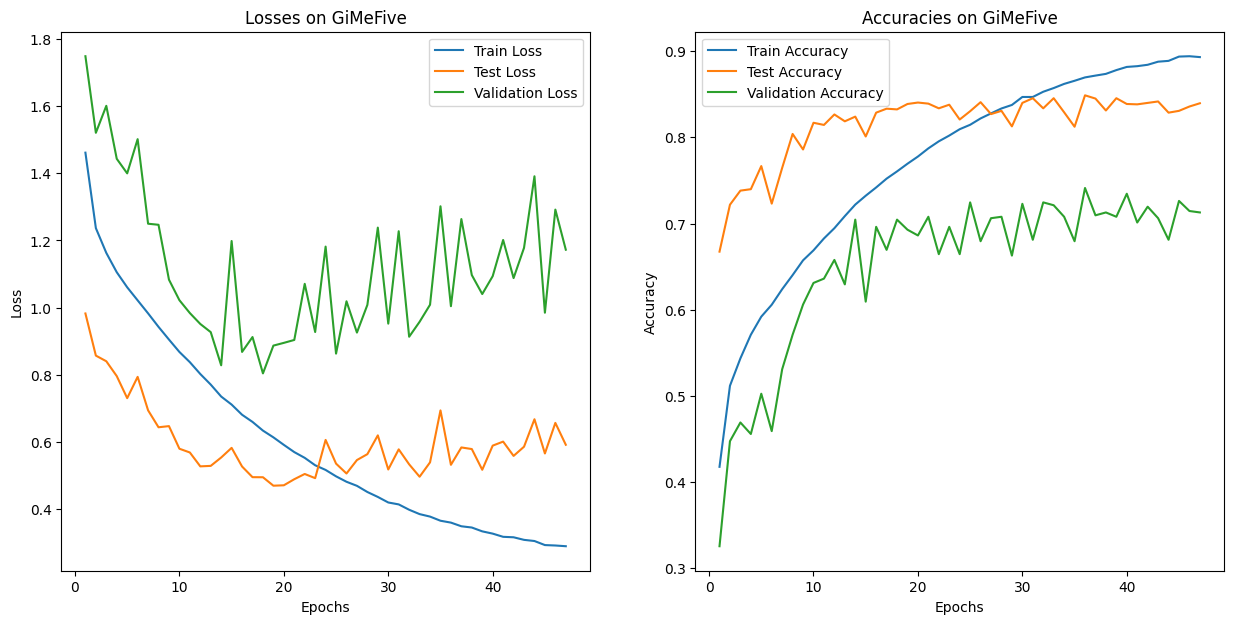

In [38]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(range(1, 48), train_losses, label='Train Loss') # change this number after '(1, _)' to num_epochs+1
plt.plot(range(1, 48), test_losses, label='Test Loss') # change this number after '(1, _)' to num_epochs+1
plt.plot(range(1, 48), val_losses, label='Validation Loss') # change this number after '(1, _)' to num_epochs+1
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Losses on GiMeFive') # change
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, 48), train_accuracies, label='Train Accuracy') # change this number after '(1, _)' to num_epochs+1
plt.plot(range(1, 48), test_accuracies, label='Test Accuracy') # change this number after '(1, _)' to num_epochs+1
plt.plot(range(1, 48), val_accuracies, label='Validation Accuracy') # change this number after '(1, _)' to num_epochs+1
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracies on GiMeFive') # change
plt.legend()

plt.show()

In [39]:
df = pd.DataFrame({
    'Epoch': range(1, 48), # change this number after '(1, _)' to num_epochs+1
    'Train Loss': train_losses,
    'Test Loss': test_losses,
    'Validation Loss': val_losses,
    'Train Accuracy': train_accuracies,
    'Test Accuracy': test_accuracies,
    'Validation Accuracy': val_accuracies
})
df.to_csv('result_5ec.csv', index=False) # change this CSV